# Deep Convolutional Neural Network

At this point, we should have understood already the concept of deep convolutional neural networks. More specifically:
1. Convolution and its parameters (kernel size, no. of filters, stride, padding)
2. The effect of depth 
3. vanishing gradient
4. Deep neural networks as learning representaion
5. Max pooling
6. Activation Functions
7. Fully Connected Layers
8. Regression vs Classification

# Cats and Dogs Classification

Earlier, we were able to look on how deep CNN was able to learn and classify handwritten digits. However, this is too controlled, this dataset cannot represent real-world images.

Thus, Let's now try to look at the power of deep learning for learning representation. We would now look at the Cats vs Dogs Dataset. These are images from [Kaggle Dataset by Microsoft](https://www.kaggle.com/c/dogs-vs-cats)




In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader


In [2]:
# Check if CUDA is available or not. Otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(24)
np.random.seed(24)

num_classes = 2

root_folder = '../datasets/catsanddogs'
data_transforms = {}
data_transforms['train'] = transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])
                                              ])

data_transforms['val'] = transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])
                                            ])

full_dataset = {}
full_dataset['train'] = datasets.ImageFolder(root=os.path.join(root_folder,'train'), transform=data_transforms['train'])
full_dataset['val'] = datasets.ImageFolder(root=os.path.join(root_folder,'val'), transform=data_transforms['val'])



## Visualizing Dataset
Let's look now how our dataset looks like.
On this example, we take the first image-label pair.

In [3]:
imageLabelpair = full_dataset['train'][0]
imageLabelpair

(tensor([[[ 2.0948,  2.0948,  2.1119,  ...,  2.1804,  2.1975,  2.1975],
          [ 2.0777,  2.0948,  2.1119,  ...,  2.1804,  2.1975,  2.1975],
          [ 2.0777,  2.0777,  2.0948,  ...,  2.1804,  2.1975,  2.1975],
          ...,
          [-0.7650, -0.7479, -0.7822,  ..., -1.7240, -1.7240, -1.7240],
          [-0.7822, -0.7822, -0.7993,  ..., -1.7412, -1.7412, -1.7069],
          [-0.7993, -0.8164, -0.7993,  ..., -1.7069, -1.7240, -1.7412]],
 
         [[ 1.5532,  1.5532,  1.5707,  ...,  1.9034,  1.9209,  1.9209],
          [ 1.5357,  1.5532,  1.5707,  ...,  1.9034,  1.9209,  1.9209],
          [ 1.5357,  1.5357,  1.5532,  ...,  1.9034,  1.9209,  1.9209],
          ...,
          [-1.0728, -1.0553, -1.0903,  ..., -1.7206, -1.7031, -1.6856],
          [-1.0903, -1.0903, -1.1078,  ..., -1.7381, -1.7206, -1.6681],
          [-1.1253, -1.1429, -1.1253,  ..., -1.7031, -1.7031, -1.7031]],
 
         [[ 0.3393,  0.3393,  0.3568,  ...,  0.8099,  0.8274,  0.8274],
          [ 0.3219,  0.3393,

As you can see, the first index tells us the index from the pool of image-label pair dataset.   
Each pair consists of: (1) Raw image in Tensor format (due to transformer), (2) Label for that annotation

Let's try to display image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


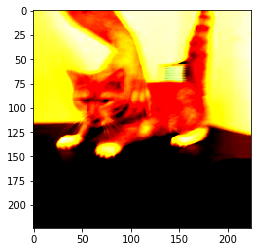

In [4]:
from IPython.display import display
plt.imshow(imageLabelpair[0].permute(1,2,0).numpy())

The one below is the label

In [5]:
imageLabelpair[1]

0

Thus, we see that we defined that a label 0 is a cat (it is zero as due to alphabetical arrangement of label)

You can try to change the value of the index. Can you try to check if you can find a dog?

## Convert Datasets into Dataloaders
- Again, the advantage is that we can convert it a iterable set of batches
- This is also where specify the parallelism of our loading

In [6]:
trainDataLoader = DataLoader(full_dataset['train'],batch_size=64,shuffle=True, pin_memory=True)
valDataLoader = DataLoader(full_dataset['val'],batch_size=64,shuffle=True, pin_memory=True)

## Very Deep Convolutional Neural Network
Reference: [Simonyan and Zisserman, 2015](https://arxiv.org/pdf/1409.1556.pdf)
- In this module, we would start studying classical deep neural network.

You can look at the paper. We've also reimplemented it as seen in [vgg16.py](vgg16.py)

In [7]:
from vgg16 import vgg16

vgg_model = vgg16(pretrained=False).to(device)
vgg_model

In [8]:
vgg_model.classifier[6] = nn.Linear(4096, num_classes)

Let's define the training parameters

In [9]:
epochs = 30 # Number of times it would repeat the whole training process

criterion = nn.CrossEntropyLoss()
# Define how we would update the weights
optimizer = torch.optim.Adam(vgg_model.parameters(),lr=0.001,betas=(0.9, 0.999))


In [10]:
%reload_ext tensorboard

In [11]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 55849), started 14:09:02 ago. (Use '!kill 55849' to kill it.)

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch.utils.tensorboard import SummaryWriter
# from visdom import Visdom

#We transferred both the model and data to GPU on trainer and evaluator
trainer = create_supervised_trainer(vgg_model,optimizer,criterion,device)
evaluator = create_supervised_evaluator(vgg_model,metrics={'accuracy':Accuracy(),
                                                      'loss':Loss(criterion)},device=device)

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
# vis = Visdom()

# def create_plot_window(vis, xlabel, ylabel, title):
#     return vis.line(X=np.array([1]), Y=np.array([np.nan]), opts=dict(xlabel=xlabel, ylabel=ylabel, title=title))

# #Initialize all the plot windows we wanted
# train_loss_window = create_plot_window(vis,'#Iterations','Loss','Training Avg Loss')
# val_loss_window = create_plot_window(vis,'#Iterations','Loss','Val Avg Loss')
# train_acc_window = create_plot_window(vis,'#Iterations','Accuracy','Training Avg Accuracy')
# val_acc_window = create_plot_window(vis,'#Iterations','Accuracy','Val Avg Accuracy')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(trainDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch
    print("Epoch: {} train Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    
    # Update your plots
    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('Accuracy/train', avg_accuracy, epoch)
#     vis.line(X=np.array([epoch]),Y=np.array([avg_loss]),win=train_loss_window,update='append')
#     vis.line(X=np.array([epoch]),Y=np.array([avg_accuracy]),win=train_acc_window,update='append')
    
    pass

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(valDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch

    print("Epoch: {} Val Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    
    # Update your plots
    writer.add_scalar('Loss/val', avg_loss, epoch)
    writer.add_scalar('Accuracy/val', avg_accuracy, epoch)
#     vis.line(X=np.array([epoch]),Y=np.array([avg_loss]),win=val_loss_window,update='append')
#     vis.line(X=np.array([epoch]),Y=np.array([avg_accuracy]),win=val_acc_window,update='append')


trainer.run(trainDataLoader, max_epochs=epochs)

/opt/anaconda3/envs/ml-detection/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/ml-detection/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/ml-detection/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/ml-detectio

Epoch: 1 train Loss: 0.6948 Acc: 50.0000
Epoch: 1 Val Loss: 0.6948 Acc: 50.0000
Epoch: 2 train Loss: 0.6932 Acc: 50.0000
Epoch: 2 Val Loss: 0.6932 Acc: 50.0000
Epoch: 3 train Loss: 0.6932 Acc: 50.0000
Epoch: 3 Val Loss: 0.6932 Acc: 50.0000
Epoch: 4 train Loss: 0.6932 Acc: 50.0000
Epoch: 4 Val Loss: 0.6932 Acc: 50.0000
Epoch: 5 train Loss: 0.6932 Acc: 50.0000
